# 전체 통계 분석

In [1]:
# import
from pymongo import MongoClient
from bson.objectid import ObjectId
from datetime import timezone, timedelta
import pandas as pd
import matplotlib.pyplot as plt

# timezone = KST
KST = timezone(timedelta(hours=9))

In [2]:
# connect with mongo
client = MongoClient("mongodb://localhost:27017/")
db = client["taxi"]
logs = client["logs"]

## 만들어진 방

In [3]:
totRooms = list(db.rooms.find())
nonZeroRooms = list(filter(lambda x: len(x["part"]) != 0, totRooms))
matchedRooms = list(filter(lambda x: len(x["part"]) > 1, totRooms))

print("전체 방의 개수 = {}".format(len(totRooms)))
print("참여 인원이 0명이 아닌 전체 방 개수 = {}".format(len(nonZeroRooms)))
print("매칭이 성공한 방 개수 = {}".format(len(matchedRooms)))

전체 방의 개수 = 528
참여 인원이 0명이 아닌 전체 방 개수 = 380
매칭이 성공한 방 개수 = 147


## 출발지/도착지 경로

In [4]:
locations = list(db.locations.find())
originDest = []
for origin in locations:
    for dest in locations:
        if origin['_id'] != dest['_id']:
            rooms = list(db.rooms.find({"from": origin['_id'], "to": dest['_id']}))
            count = [len(list(filter(lambda x: len(x["part"]) == i, rooms))) for i in range(5)]
            if sum(count) == 0: break
            originDest.append({
                "path": "{} -> {}".format(origin["koName"], dest["koName"]),
                "count": count,
            })
            
originDest.sort(key=lambda x: sum(x["count"]), reverse=True)
divide = lambda x, y: x / y if y != 0 else 0
totCountRoom = sum([sum(x['count']) for x in originDest])

print("전체 방 개수 = {}".format(totCountRoom))
pd.DataFrame(data={
    "경로": [x['path'] for x in originDest],
    "방개수": [sum(x['count']) for x in originDest],
    "방개수 / 전체": [sum(x['count']) / totCountRoom for x in originDest],
    "참여인원이 4명 / 방개수": [x['count'][4] / sum(x['count']) for x in originDest],
    "참여인원이 3명 / 방개수": [x['count'][3] / sum(x['count']) for x in originDest],
    "참여인원이 2명 / 방개수": [x['count'][2] / sum(x['count']) for x in originDest],
    "참여인원이 1명 / 방개수": [x['count'][1] / sum(x['count']) for x in originDest],
    "참여인원이 0명 / 방개수": [x['count'][0] / sum(x['count']) for x in originDest],
    "매칭 성공 비율": [divide((sum(x['count']) - x['count'][0] - x['count'][1]), (sum(x['count']) - x['count'][0])) for x in originDest],
}).style.hide(axis='index')

전체 방 개수 = 475


경로,방개수,방개수 / 전체,참여인원이 4명 / 방개수,참여인원이 3명 / 방개수,참여인원이 2명 / 방개수,참여인원이 1명 / 방개수,참여인원이 0명 / 방개수,매칭 성공 비율
대전역 -> 카이스트 본원,203,0.427368,0.133005,0.088670,0.108374,0.408867,0.261084,0.446667
카이스트 본원 -> 대전역,183,0.385263,0.087432,0.060109,0.163934,0.398907,0.289617,0.438462
카이스트 본원 -> 서대전역,17,0.035789,0.000000,0.000000,0.117647,0.764706,0.117647,0.133333
서대전역 -> 카이스트 본원,16,0.033684,0.000000,0.000000,0.250000,0.625000,0.125000,0.285714
대전복합터미널 -> 카이스트 본원,12,0.025263,0.000000,0.000000,0.250000,0.250000,0.500000,0.500000
유성 고속버스터미널 -> 카이스트 본원,11,0.023158,0.000000,0.090909,0.000000,0.636364,0.272727,0.125000
카이스트 본원 -> 대전복합터미널,10,0.021053,0.100000,0.100000,0.000000,0.500000,0.300000,0.285714
카이스트 본원 -> 궁동 로데오거리,6,0.012632,0.333333,0.166667,0.000000,0.333333,0.166667,0.600000
궁동 로데오거리 -> 카이스트 본원,4,0.008421,0.250000,0.250000,0.000000,0.250000,0.250000,0.666667
카이스트 본원 -> 갤러리아 타임월드,3,0.006316,0.000000,0.000000,0.000000,0.666667,0.333333,0.000000


## 생성일 기준 요일 별 만들어진 방 개수

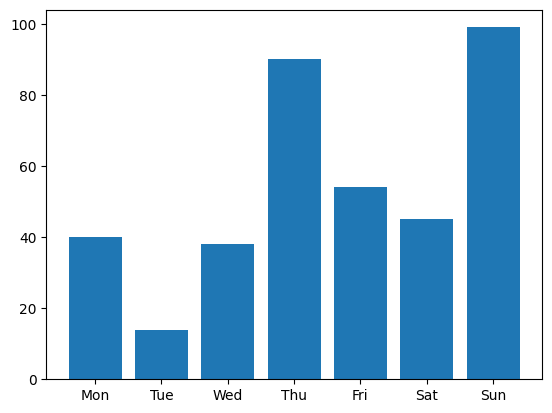

In [5]:
roomsWithWeek = [[] for _ in range(7)]
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for room in totRooms:
    if len(room["part"]) == 0: continue
    roomsWithWeek[room["madeat"].weekday()].append(room)

x = range(7)
plt.bar(x, [len(x) for x in roomsWithWeek])
plt.xticks(x, weekdays)
plt.show()

## 출발일 기준 요일 별 만들어진 방 개수

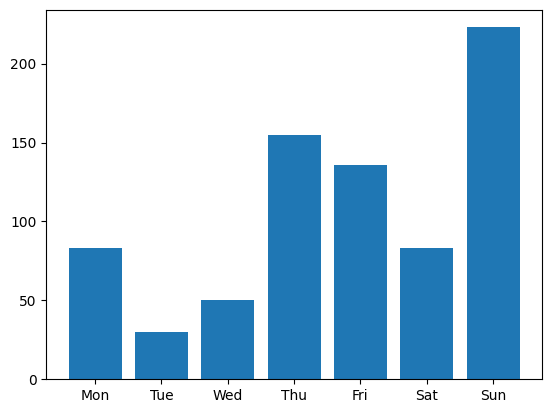

In [6]:
for room in totRooms:
    if len(room["part"]) == 0: continue
    roomsWithWeek[room["time"].weekday()].append(room)

x = range(7)
plt.bar(x, [len(x) for x in roomsWithWeek])
plt.xticks(x, weekdays)
plt.show()

## 대전역 -> 카이스트본원 출발시각

대전역 -> 카이스트 방 개수 = 203


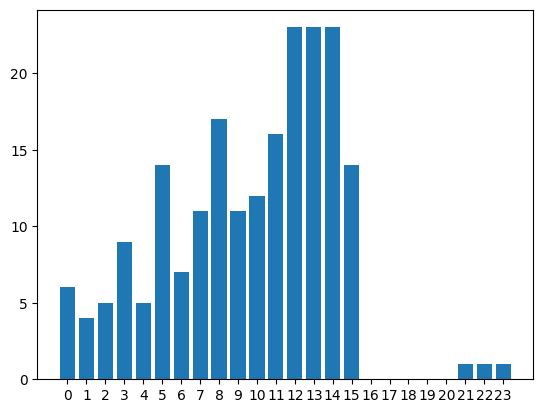

In [7]:
locationDaejeon = db.locations.find_one({"_id": ObjectId("636c70c408eab94199a3cc05")})
locationKaist = db.locations.find_one({"_id": ObjectId("636c70c308eab94199a3cbff")})

rooms = list(db.rooms.find({"from": locationDaejeon["_id"], "to": locationKaist["_id"]}))
print("대전역 -> 카이스트 방 개수 = {}".format(len(rooms)))

hourCount = [0] * 24
for room in rooms:
    hour = room["time"].astimezone(KST).hour
    hourCount[hour] += 1

x = range(len(hourCount))
plt.bar(x, hourCount)
plt.xticks(x, [i for i in range(len(hourCount))])
plt.show()

## 카이스트본원 -> 대전역 출발시각

카이스트본원 -> 대전역 방 개수 = 183


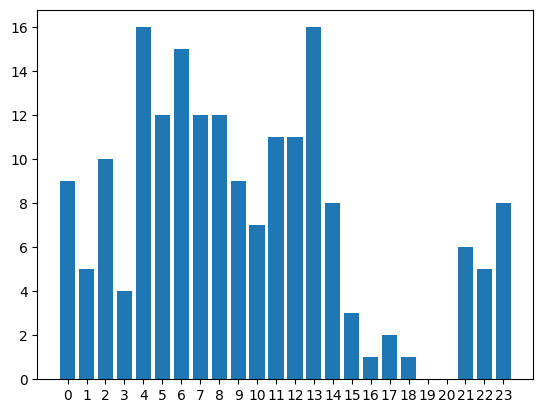

In [8]:
rooms = list(db.rooms.find({"from": locationKaist["_id"], "to": locationDaejeon["_id"]}))
print("카이스트본원 -> 대전역 방 개수 = {}".format(len(rooms)))

hourCount = [0] * 24
for room in rooms:
    hour = room["time"].astimezone(KST).hour
    hourCount[hour] += 1

x = range(len(hourCount))
plt.bar(x, hourCount)
plt.xticks(x, [i for i in range(len(hourCount))])
plt.show()

## 유저 별 방 생성 개수

전체 사용자 수 = 1003


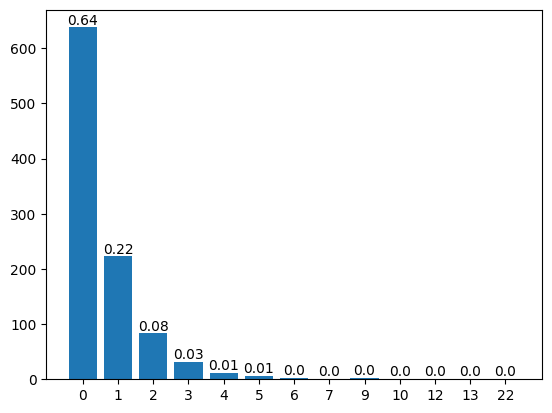

In [9]:
partCount = {}
users = list(db.users.find())
print("전체 사용자 수 = {}".format(len(users)))

for user in users:
    cnt = len(user["ongoingRoom"]) + len(user["doneRoom"])
    if cnt not in partCount: partCount[cnt] = 0
    partCount[cnt] += 1

partCount = list(partCount.items())
partCount.sort(key=lambda x: x[0])

x = range(len(partCount))
plt.bar(x, [x[1] for x in partCount])
plt.xticks(x, [x[0] for x in partCount])
for i, v in enumerate(partCount):
    plt.text(i, v[1], round(v[1] / sum([x[1] for x in partCount]), 2), horizontalalignment='center', verticalalignment='bottom')
plt.show()

## 방 출발 시각 - 생성 시각 차이

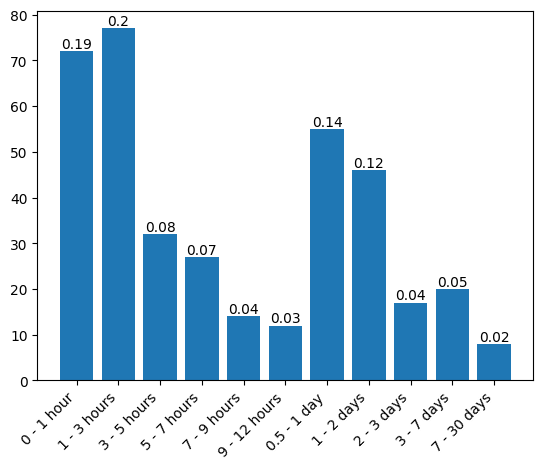

In [10]:
diffs = [
    (timedelta(hours = 1), "0 - 1 hour"),
    (timedelta(hours = 3), "1 - 3 hours"),
    (timedelta(hours = 5), "3 - 5 hours"),
    (timedelta(hours = 7), "5 - 7 hours"),
    (timedelta(hours = 9), "7 - 9 hours"),
    (timedelta(hours = 12), "9 - 12 hours"),
    (timedelta(days = 1), "0.5 - 1 day"),
    (timedelta(days = 2), "1 - 2 days"),
    (timedelta(days = 3), "2 - 3 days"),
    (timedelta(days = 7), "3 - 7 days"),
    (timedelta(days = 30), "7 - 30 days"),
]
diffCount = [0] * len(diffs)
for room in totRooms:
    if len(room["part"]) == 0: continue
    diff = room["time"] - room["madeat"]
    for i, (d, _) in enumerate(diffs):
        if diff <= d:
            diffCount[i] += 1
            break

x = range(len(diffs))
fig, ax = plt.subplots()
plt.bar(x, diffCount)
plt.xticks(x, [y for _, y in diffs])
for i, v in enumerate(x):
    plt.text(v, diffCount[i], round(diffCount[i] / sum(diffCount), 2), horizontalalignment='center', verticalalignment='bottom')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## 방 참여 시각 - 방 출발 시각 차이

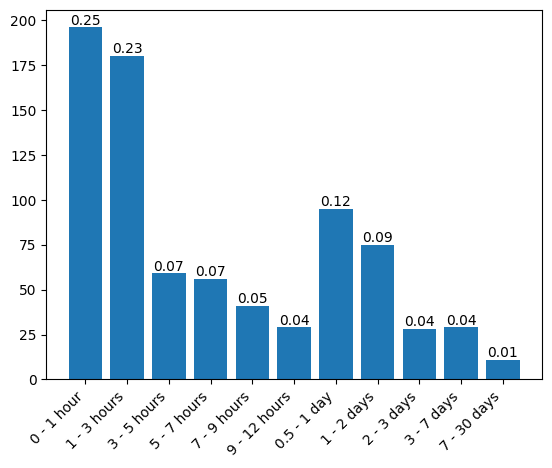

In [11]:
diffCount = [0] * len(diffs)
for room in totRooms:
    if len(room["part"]) == 0: continue
    chats = list(db.chats.find({"roomId": room["_id"], "type": "in"}))
    for chat in chats:
        diff = room["time"] - chat["time"]
        for i, (d, _) in enumerate(diffs):
            if diff <= d:
                diffCount[i] += 1
                break

x = range(len(diffs))
fig, ax = plt.subplots()
plt.bar(x, diffCount)
plt.xticks(x, [y for _, y in diffs])
for i, v in enumerate(x):
    plt.text(v, diffCount[i], round(diffCount[i] / sum(diffCount), 2), horizontalalignment='center', verticalalignment='bottom')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## 방의 각 사용자 정산 여부

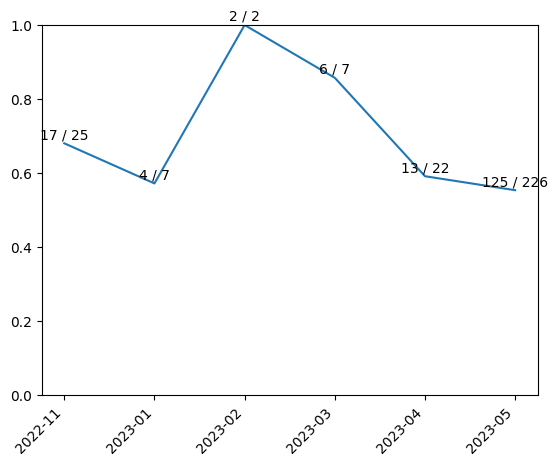

In [12]:
settlementCount = {}
for room in totRooms:
    if len(room["part"]) <= 1: continue
    for part in room["part"]:
        timestr = room["time"].strftime('%Y-%m')
        if part["settlementStatus"] == "paid" or part["settlementStatus"] == "sent":
            if timestr not in settlementCount: settlementCount[timestr] = (0, 0)
            settlementCount[timestr] = (settlementCount[timestr][0] + 1, settlementCount[timestr][1] + 1)
        elif part["settlementStatus"] == "send-required":
            if timestr not in settlementCount: settlementCount[timestr] = (0, 0)
            settlementCount[timestr] = (settlementCount[timestr][0], settlementCount[timestr][1] + 1)


settlementCount = list(settlementCount.items())
settlementCount.sort(key=lambda x: x[0])

fig, ax = plt.subplots()
plt.plot([x[0] for x in settlementCount], [x[1][0] / x[1][1] for x in settlementCount])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for x, y in settlementCount:
    plt.text(x, y[0] / y[1] + 0.005, "{} / {}".format(y[0], y[1]), horizontalalignment='center', verticalalignment='bottom')
plt.ylim([0, 1])
plt.show()

## 방의 계좌번호 정산 기능 사용 여부

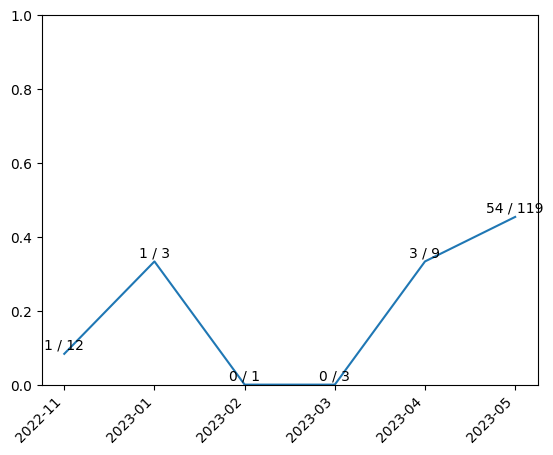

In [13]:
settlementCount = {}
for room in totRooms:
    if len(room["part"]) <= 1: continue
    timestr = room["time"].strftime('%Y-%m')
    if timestr not in settlementCount: settlementCount[timestr] = (0, 0)
    chats = list(db.chats.find({"roomId": room["_id"], "type": "account"}))
    settlementCount[timestr] = (settlementCount[timestr][0] + (1 if len(chats) > 0 else 0), settlementCount[timestr][1] + 1)

settlementCount = list(settlementCount.items())
settlementCount.sort(key=lambda x: x[0])

fig, ax = plt.subplots()
plt.plot([x[0] for x in settlementCount], [x[1][0] / x[1][1] for x in settlementCount])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for x, y in settlementCount:
    plt.text(x, y[0] / y[1] + 0.005, "{} / {}".format(y[0], y[1]), horizontalalignment='center', verticalalignment='bottom')
plt.ylim([0, 1])
plt.show()

## 방 정산 시각 - 방 출발 시각 차이

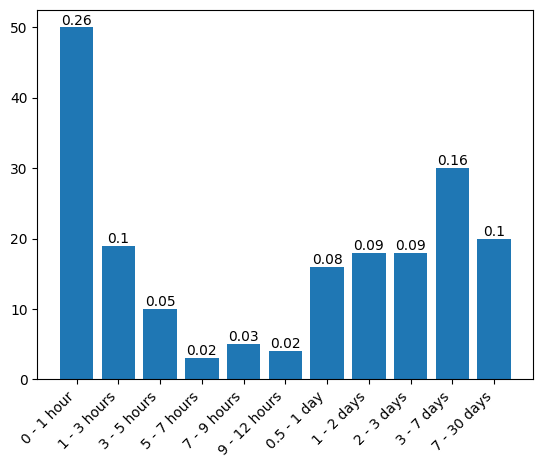

In [14]:
diffCount = [0] * len(diffs)
for room in totRooms:
    for part in room["part"]:
        chats = list(db.chats.find({"roomId": room["_id"], "authorId": part["user"], "$or": [{"type": "payment"}, {"type": "settlement"}]}))
        chats.sort(key=lambda x: x["time"])
        if len(chats) <= 0: continue
        diff = chats[0]["time"] - room["time"]
        for i, (d, _) in enumerate(diffs):
            if diff <= d:
                diffCount[i] += 1
                break

x = range(len(diffs))
fig, ax = plt.subplots()
plt.bar(x, diffCount)
plt.xticks(x, [y for _, y in diffs])
for i, v in enumerate(x):
    plt.text(v, diffCount[i], round(diffCount[i] / sum(diffCount), 2), horizontalalignment='center', verticalalignment='bottom')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## 이용 학번 분포
여러번 방에 참가한 사용자는 중복되어 통계되도록 하였습니다.
마찬가지로 서비스 가입만 하고 방에 참여하지 않은 사용자는 통계에 포함되지 않습니다.

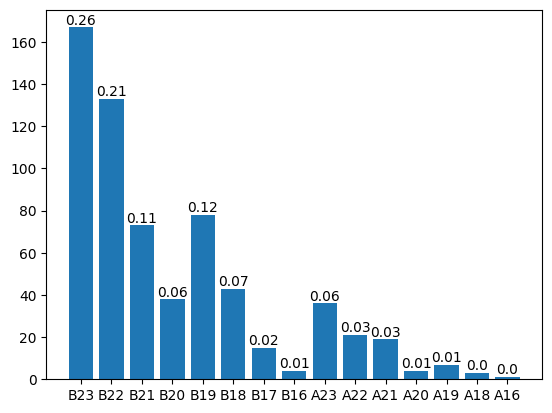

In [15]:
idCount = {}
for room in totRooms:
    for part in room["part"]:
        user = db.users.find_one({"_id": part["user"]})
        if user is None: continue
        kaistId = user["subinfo"]["kaist"]
        if len(kaistId) != 8: continue
        year = kaistId[2:4]
        prefix = "B" if kaistId[4] == "0" else "A"
        if prefix + year not in idCount: idCount[prefix + year] = 0
        idCount[prefix + year] += 1

idCount = list(idCount.items())
idCount.sort(key=lambda x: x[0], reverse=True)

x = range(len(idCount))
plt.bar(x, [x[1] for x in idCount])
plt.xticks(x, [x[0] for x in idCount])
for i, v in enumerate(idCount):
    plt.text(i, v[1], round(v[1] / sum([x[1] for x in idCount]), 2), horizontalalignment='center', verticalalignment='bottom')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()